In [1]:
!pip install tensorflow
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from pathlib import Path

2025-12-03 05:31:31.968753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764739891.994307     116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764739892.001723     116 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATA_DIR = "/kaggle/input/histopathologic-cancer-detection"
train_data = pd.read_csv(DATA_DIR + "/train_labels.csv")
print(train_data.shape)
print(train_data.head(5))
train_data.describe()

# Check if there are any null entries.
total_nan_count = train_data.isnull().sum().sum()
print("Total null entries: ", total_nan_count)
assert total_nan_count == 0

# Check if there are duplicate rows.
duplicates = train_data.duplicated()
print("Total duplicates: ", duplicates.sum())

(220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Total null entries:  0
Total duplicates:  0


The link to the github repo is [Github repo](https://github.com/asankaran35/DTSA-5511-Week-3-CNN).

This dataset consists of unique image patches and their respective labels (0 or 1) which represent whether the patch contains at least one pixel of tumor tissue in its center. Each image is represented with its own ID. The goal of this study is to create a deep learning algorithm that classifies images as containing cancer or not containing cancer/cancer-free.

The dataset doesn't contain any duplicates nor null/missing values. It has 220,025 rows and 2 columns. The 2 columns are "id" and "label".

Below is a bar chart plotting the frequency of 0's and 1's.

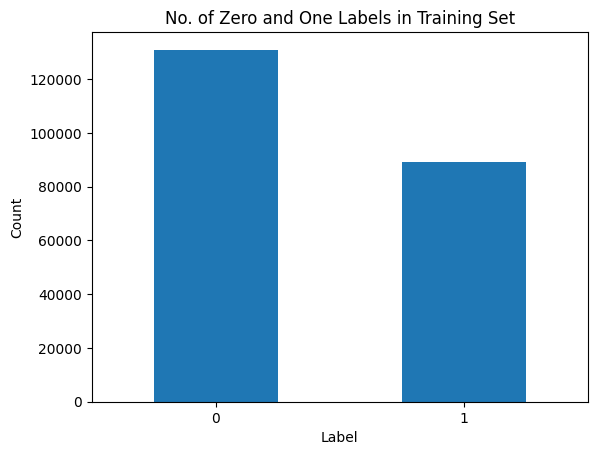

In [3]:
label_counts = train_data['label'].value_counts()
fig, ax = plt.subplots()
label_counts.plot(kind='bar', ax=ax)
plt.title('No. of Zero and One Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The above bar plot shows the number of images classified as 0 (no cancer) is greater than the number of images classified as 1 (cancer exists). Now I will load the images into a keras dataset that I can then feed into a Convolutional Neural Network (CNN) model. I will use a resized dataset that has the images in .png format so that they can be loaded using the "image_dataset_from_directory" function from keras. The resulting datasets will be a training set with 80% of the images and a validation set with the other 20%.

In [4]:
# Define parameters
image_height = 224
image_width = 224
batch_size = 32

RESIZED_DATA_DIR = "/kaggle/input/histopathologic-cancer-detection-resized"

# Create training and validation datasets
train_img_ds_1 = tf.keras.utils.image_dataset_from_directory(
    RESIZED_DATA_DIR + "/converted_train/converted_train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

val_img_ds_1 = tf.keras.utils.image_dataset_from_directory(
    RESIZED_DATA_DIR + "/converted_train/converted_train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

# Find the total number of elements for a good shuffle buffer size
# This might require iterating through the datasets, or you can estimate.
# A large number like 1000 or a high percentage of your total dataset size works well.
total_elements_train = tf.data.experimental.cardinality(train_img_ds_1).numpy() * 32
train_img_shuffled = train_img_ds_1.shuffle(buffer_size=total_elements_train)

total_elements_val = tf.data.experimental.cardinality(val_img_ds_1).numpy() * 32
val_img_shuffled = val_img_ds_1.shuffle(buffer_size=total_elements_val)

train_img_shuffled = train_img_shuffled.cache()
val_img_shuffled = val_img_shuffled.cache()

print("Dataset element_spec:")
print(train_img_shuffled.element_spec)
print(val_img_shuffled.element_spec)

Found 4505 files belonging to 2 classes.
Using 3604 files for training.
Found 4505 files belonging to 2 classes.


2025-12-03 05:31:40.788522: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Using 901 files for validation.
Dataset element_spec:
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Now that the images are loaded into the keras dataset, I will start the training process by defining a Convolutional Neural Network (CNN) model using the Sequential API from keras. The model will follow this structure.

1. Input Layer: Normalize/rescale the pixel values of the input images.
2. Convolutional Layer: Apply filters on the images to extract the feature maps. This will also include pooling to reduce computational cost and prevent overfitting.
3. Output/Dense Layer: Returns the probability of the label being in the positive class (label equals 1).

In [5]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(image_height, image_width, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

I will now compile the above model. The parameters I will specify in the compile method are the optimizer, loss function, and metrics.
1. optimizer: adam
2. loss function: binary_crossentropy
3. metrics: accuracy

In [6]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

The next step is the training of the model and its evaluation against the validation set. Lets set the number of iterations (epochs) equal to 10 to start off with.

In [7]:
epochs = 10
history = model.fit(
    train_img_shuffled,
    validation_data=val_img_shuffled,
    epochs=epochs
)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 100s 824ms/step - accuracy: 0.5917 - loss: 0.7752 - val_accuracy: 0.8024 - val_loss: 0.4754
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 90s 793ms/step - accuracy: 0.7687 - loss: 0.5000 - val_accuracy: 0.7980 - val_loss: 0.4649
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 94s 833ms/step - accuracy: 0.7699 - loss: 0.4848 - val_accuracy: 0.7802 - val_loss: 0.4735
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 93s 823ms/step - accuracy: 0.7820 - loss: 0.4696 - val_accuracy: 0.7725 - val_loss: 0.4787
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 89s 790ms/step - accuracy: 0.8121 - loss: 0.4156 - val_accuracy: 0.7825 - val_loss: 0.4834
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 90s 797ms/step - accuracy: 0.8551 - loss: 0.3383 - val_accuracy: 0.7991 - val_loss: 0.5426
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 90s 795ms/step - accuracy: 0.8775 - loss: 0.2982 - val_accuracy: 0.7525 - val_loss: 0.7493
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 94s 834ms/step - accuracy: 0.8965 - loss: 

Lets plot the accuracy and loss values for both the training and validation sets.

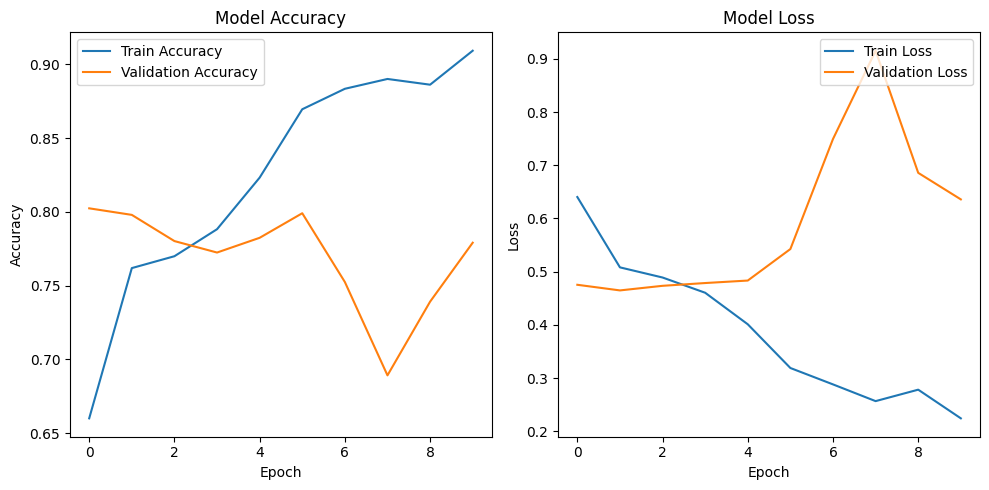

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Based on the above plots, the ideal number of epochs looks to be 2. Around that point is where the validation loss is at its minimum and the validation accuracy is at one of its highest peaks. Lets run the training again with the epochs set to 2.

In [10]:
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(image_height, image_width, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 2
history_2 = model_2.fit(
    train_img_shuffled,
    validation_data=val_img_shuffled,
    epochs=epochs
)

Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 91s 791ms/step - accuracy: 0.5766 - loss: 0.8086 - val_accuracy: 0.8013 - val_loss: 0.4713
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 93s 822ms/step - accuracy: 0.7592 - loss: 0.5229 - val_accuracy: 0.8302 - val_loss: 0.4275


With the number of epochs as 2, the validation accuracy is the highest so far and the validation loss is the lowest.

Lets do some additional hyperparameter tuning. Specifically, I will look into decreasing the learning rate to making it more conservative. One thing to notice from the plots of accuracy and loss when epochs = 10 is how the validation data metrics stayed approximately the same for a number of epochs before changing. This could mean the model is struggling to converge/learn and because it is struggling, it hovers around in the same area for a good duration of the training process. My theory is reducing the learning rate will cause the model to take smaller steps in the learning process which will hopefully lead to it finding a direction to proceed in. I will reduce the learning rate from 0.001 to 0.0005.

In [13]:
model_3 = tf.keras.Sequential([
    tf.keras.Input(shape=(image_height, image_width, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model_3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 2
history_3 = model_3.fit(
    train_img_shuffled,
    validation_data=val_img_shuffled,
    epochs=epochs
)

Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 91s 790ms/step - accuracy: 0.5286 - loss: 0.7200 - val_accuracy: 0.7913 - val_loss: 0.4950
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 142s 790ms/step - accuracy: 0.7340 - loss: 0.5337 - val_accuracy: 0.8180 - val_loss: 0.4516


Based on the results, the validation accuracy and loss got worse for both epochs. Even though the number of epochs is considerably small at 2, I will conclude that the learning rate reduction from 0.001 to 0.0005 is not an optimization that will improve this model. Other hyperparameters should be looked at and tuned to improve the model's performance.

I will now take model #2 (model_2 variable) and use it to predict the labels for the test dataset. Then I will create a dataframe with the image id and corresponding predicted label and export it as a .csv file for submission.

In [17]:
# Use same parameters as for training data
image_height = 224
image_width = 224
batch_size = 32

RESIZED_TEST_DATA_DIR = "/kaggle/input/histopathologic-cancer-detection-resized"

# Create test dataset
test_img_ds = tf.keras.utils.image_dataset_from_directory(
    RESIZED_DATA_DIR + "/converted_test",
    labels=None,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    interpolation='nearest',
    shuffle=False
)

predictions = model_2.predict(test_img_ds)
predicted_classes = (predictions > 0.5).astype(int)

print("Finished predictions.")


Found 57437 files.
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 437s 243ms/step
Finished predictions.


In [18]:
import os

filenames = test_img_ds.file_paths

# Extract just the filename without the extension
image_ids = [os.path.splitext(os.path.basename(f))[0] for f in filenames]

print("Extracted all image filenames.")

# Create a pandas DataFrame
results_df = pd.DataFrame({
    'id': image_ids,
    'label': predicted_classes.flatten()
})

print(results_df.shape)
print(results_df.head(5))

Extracted all image filenames.
(57437, 2)
                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      0
1  0000ec92553fda4ce39889f9226ace43cae3364e      0
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      0
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      0
4  000270442cc15af719583a8172c87cd2bd9c7746      0


The converted test set is missing 21 images which could not be converted from .tiff to .png format. The submission requires all the images to be in the dataframe, so I will manually add the missing 21 images and set their predictions to 0.

In [ ]:
missing_filenames = ['b24dd7dd09e783955ee4e9a7818481d6b4cd1bf2.tif','b24fdc70b9a51017a8e66df1b8ccfa5c5e10ed3d.tif',
'b24de9ac61d83ddcd01b10b63770030da33e43f5.tif','b24d2611bb3c53372a448cb1b066987c210dcc70.tif',
'b249d54abd567198cb054465adc25b1e207ea818.tif','b24d585997ebeb88a47e3614d7971c42a3fca161.tif',
'6b359ce7274933a5391385c02bc7220fe74f20e2.tif','6b3915d3717e80a9629230b5d2b094b26c4f5a00.tif',
'6b3acd84218d660fd78fd0f5875e668d27530e81.tif','6b34683e56087e300bd7b00a8bc92df3b1027641.tif',
'6b3993a29333f2de3928c3d3f49825535b574371.tif','6b32ed56e1958da53c9d292a5c2e9653202e95a3.tif',
'6573f27b6cd26f7ff6f23c11386a2a33470bd9e4.tif','65736b78f7f885c8c3bc6e88664b4428c6421ff7.tif',
'6575268356d01d053bbdc6e2cb1325efab940f01.tif','6570bad525ae63abe46cad6a7559765afdc1f90c.tif',
'6575a96644a66860039f367f5fbc2059b71cd2f9.tif','39c62fd8cc76fe28cc3a16787f192e2f48f7f31a.tif',
'39c5e29c436bdc38b3c7dd18f301a4b2a837f921.tif','39c74bc299b478b985cc4ae321c5a5c08614293c.tif',
'39c8a7e15221a8167f36d76e19224ea52d0efc15.tif'
]

missing_imgs = [file_img[:-4] for file_img in missing_filenames]
missing_labels = [0] * len(missing_filenames)
missing_data = {'id': missing_imgs, 'label': missing_labels}
missing_df = pd.DataFrame(missing_data)

# Concatenate both data frames
results_df = pd.concat([results_df, missing_df], ignore_index=True)

In [19]:
# Export pandas dataframe to .csv file for submission
output_csv_filename = '/kaggle/working/predicted-results-submission.csv'
results_df.to_csv(output_csv_filename, index=False)

print(f'Submission file created successfully: {output_csv_filename}')

Submission file created successfully: /kaggle/working/predicted-results-submission.csv


**Conclusion**

Tweaking the number of epochs helped improve the model's performance, whereas reducing the learning rate didn't help it. Some improvements I can make in the future is making changes to the Sequential model, specifically the hidden layers.